In [ ]:
#출처 : https://github.com/albertauyeung/matrix-factorization-in-python/blob/master/mf.py



matrix factorization 식 구현 : class mf
(mf 만 무조건 좋다? no, 사례 및 아이템에 맞게 구현하는 것이 중요함)

In [1]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
path = 'C:/Users/kt NexR/PycharmProjects/Recommendation-algorithms/Classic_recommendation_algorithms/collaborative-filtering/data'
ratings_df = pd.read_csv(path + '/ratings.csv', encoding='utf-8')

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)
train_df = train_df[:1000]

(80668, 4)
(20168, 4)


In [22]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix = sparse_matrix.fillna(0)

# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# # fill sparse matrix with average of user ratings
# sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [23]:
sparse_matrix = sparse_matrix.to_numpy()
sparse_matrix_withmovie = sparse_matrix_withmovie.to_numpy()
sparse_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            # if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [25]:
mf = MF(sparse_matrix, K=50, alpha=0.1, beta=0.01, iterations=20)

In [26]:
training_process = mf.train()

Iteration: 1 ; error = 25.1014
Iteration: 2 ; error = 21.4492
Iteration: 3 ; error = 18.7289
Iteration: 4 ; error = 16.5606
Iteration: 5 ; error = 14.7396
Iteration: 6 ; error = 13.0590
Iteration: 7 ; error = 11.5591
Iteration: 8 ; error = 10.1702
Iteration: 9 ; error = 8.9463
Iteration: 10 ; error = 7.8585
Iteration: 11 ; error = 6.8951
Iteration: 12 ; error = 6.0561
Iteration: 13 ; error = 5.3185
Iteration: 14 ; error = 4.6778
Iteration: 15 ; error = 4.1329
Iteration: 16 ; error = 3.6581
Iteration: 17 ; error = 3.2486
Iteration: 18 ; error = 2.8992
Iteration: 19 ; error = 2.5989
Iteration: 20 ; error = 2.3405


In [14]:
sparse_matrix.shape

(8938, 610)

In [27]:
mf.full_matrix()

array([[4.79867913, 4.81845785, 4.4733985 , ..., 3.90777205, 3.67071439,
        4.09474489],
       [4.19423187, 4.1901338 , 3.86537405, ..., 3.30912751, 3.06898761,
        3.43196595],
       [3.71504455, 3.70955752, 3.40011972, ..., 2.83475176, 2.61395586,
        2.92026258],
       ...,
       [4.1093981 , 4.09879541, 3.7830806 , ..., 3.21483373, 2.99465174,
        3.34054474],
       [4.38682641, 4.37760714, 4.06963315, ..., 3.50301406, 3.28861141,
        3.63289394],
       [3.86305035, 3.86071336, 3.53843512, ..., 2.96802212, 2.75364606,
        3.13199148]])

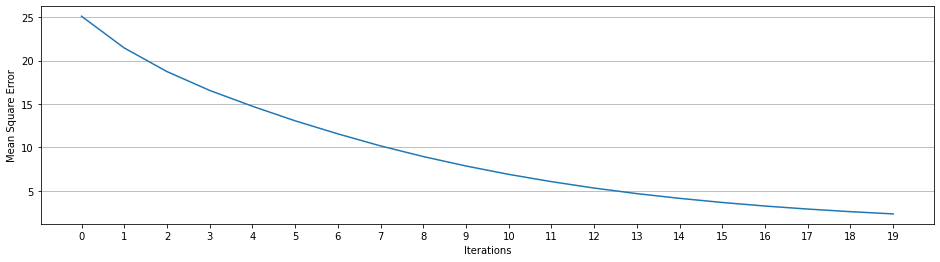

In [28]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")